## Project: Bike counts on East River Bridges prediction using machine learning
- **Source**: Sachin Date, Statistical Modeling and Forecasting, 
- **URL**: https://data.cityofnewyork.us/Transportation/Bicycle-Counts-for-East-River-Bridges-Historical-/gua4-p9wg/about_data
- **Date**: 29/11/24
- **Goal**: Create a basic prediction model and a feature explainer

In [1]:
# Step 0. Load libraries and custom modules
# Basics ---------------------------------------------------------------
import os
import joblib
import logging
# Data -----------------------------------------------------------------
import pandas as pd
import numpy as np
from patsy import dmatrices
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
# Time series ----------------------------------------------------------
from statsmodels.tsa.seasonal import seasonal_decompose
# Machine learning -----------------------------------------------------
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)
# Logging initialization -----------------------------------------------
logger = logging.getLogger()
logger.setLevel(logging.INFO)

### 1. Data loading
**Objective**: Obtain the data from source and get a first glimpse of their properties and presentation

In [2]:
# Step 1. Load data
# 1.1 Retrieve data from source and get basic info
url = (
    'https://gist.githubusercontent.com/sachinsdate/' + 
    'c17931a3f000492c1c42cf78bf4ce9fe/raw/' + 
    '7a5131d3f02575668b3c7e8c146b6a285acd2cd7/' + 
    'nyc_bb_bicyclist_counts.csv'
)
df_raw = pd.read_csv(url)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      214 non-null    object 
 1   HIGH_T    214 non-null    float64
 2   LOW_T     214 non-null    float64
 3   PRECIP    214 non-null    float64
 4   BB_COUNT  214 non-null    int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 8.5+ KB


In [3]:
# 1.2 Show a sample
df_raw.sample(10, random_state=2024)

,Date,HIGH_T,LOW_T,PRECIP,BB_COUNT
143,22-Aug-17,88.0,75.0,0.30,2983
78,18-Jun-17,84.0,72.0,0.01,2199
49,20-May-17,64.0,55.9,0.01,2161
33,4-May-17,63.0,50.0,0.00,3019
116,26-Jul-17,75.9,66.0,0.00,3821
171,19-Sep-17,78.1,69.1,0.22,2012
72,12-Jun-17,91.9,77.0,0.00,2854
117,27-Jul-17,77.0,66.9,0.01,3287
133,12-Aug-17,75.9,64.9,0.11,4146
92,2-Jul-17,87.1,73.0,0.00,2467


**Data dictionary**

|Variable Name|Role|Type|Description|Units|Missing Values|
|-------------|----|----|-----------|-----|--------------|
|date|index|datetime|Date of count|yyyy-mm-dd|no|
|high_t|feature|float|Highest temperature record|F|no|
|low_t|feature|float|Lowest temperature record|F|no|
|precip|feature|float|Precipitation registered|F|no|
|bb_count|target|integer|Bike count registered|F|no|

### 2. Data preprocessing
**Objectives**: Perform the data cleaning, data transformation and data reduction steps to avoid data mistmatching, noisy data or data not wrangled

In [4]:
# Step 2. Perform data preprocessing as expected by your data dictionary
# 2.1 Make the chain for transformations
df = (
    df_raw
    .copy()
    .set_axis(
        df_raw.columns.str.replace(' ','_')
        .str.replace(r'\W','',regex=True)
        .str.lower()
        .str.slice(0,40), axis=1
    )
    .drop_duplicates()
    .rename(columns={'bb_count':'target'})
    .astype({'date':'datetime64[ns]'})
    .assign(
        month = lambda x: x['date'].dt.month,
        day = lambda x: x['date'].dt.day,
        day_of_week = lambda x: x['date'].dt.dayofweek,
        lagged_two_week = lambda x: x['target'].shift(15)
    )
    .iloc[:, [4] + [c for c in range(9) if c!= 4]]
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   target           214 non-null    int64         
 1   date             214 non-null    datetime64[ns]
 2   high_t           214 non-null    float64       
 3   low_t            214 non-null    float64       
 4   precip           214 non-null    float64       
 5   month            214 non-null    int32         
 6   day              214 non-null    int32         
 7   day_of_week      214 non-null    int32         
 8   lagged_two_week  199 non-null    float64       
dtypes: datetime64[ns](1), float64(4), int32(3), int64(1)
memory usage: 12.7 KB


In [5]:
# 2.2 Show final dataset
df

,target,date,high_t,low_t,precip,month,day,day_of_week,lagged_two_week
0,606,2017-04-01,46.0,37.0,0.00,4,1,5,NaN
1,2021,2017-04-02,62.1,41.0,0.00,4,2,6,NaN
2,2470,2017-04-03,63.0,50.0,0.03,4,3,0,NaN
3,723,2017-04-04,51.1,46.0,1.18,4,4,1,NaN
4,2807,2017-04-05,63.0,46.0,0.00,4,5,2,NaN
...,...,...,...,...,...,...,...,...,...
209,3150,2017-10-27,62.1,48.0,0.00,10,27,4,2411.0
210,2245,2017-10-28,68.0,55.9,0.00,10,28,5,2839.0
211,183,2017-10-29,64.9,61.0,3.03,10,29,6,2021.0
212,1428,2017-10-30,55.0,46.0,0.25,10,30,0,2169.0


### 3. Exploratory Data Analysis
**Objective**: Summarize the main characteristics of the dataset using descriptive statistics and data visualization methods

In [6]:
# 3.1 Create train and test splits
X = df.copy().drop('target', axis=1)
y = df['target'].copy()
horizon = 15
X_train, X_test = X.iloc[:-horizon,:], X.iloc[-horizon:,:]
y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]
df_train = pd.concat([y_train, X_train], axis=1)
df_test = pd.concat([y_test, X_test], axis=1)

In [7]:
# 3.2 Show descriptive statistics
display(df_train.describe(include='number').T)
display(df_train.describe(include='datetime').T)

,count,mean,std,min,25%,50%,75%,max
target,199.0,2692.824121,848.795114,151.0,2299.0,2860.0,3296.50,4960.00
high_t,199.0,74.775879,10.343935,46.0,66.9,75.9,82.90,93.90
low_t,199.0,62.593970,9.219000,37.0,55.9,64.9,70.00,78.10
precip,199.0,0.124925,0.351260,0.0,0.0,0.0,0.04,3.02
month,199.0,6.783920,1.893248,4.0,5.0,7.0,8.00,10.00
day,199.0,15.170854,8.792843,1.0,8.0,15.0,23.00,31.00
day_of_week,199.0,3.010050,2.017574,0.0,1.0,3.0,5.00,6.00
lagged_two_week,184.0,2693.891304,852.548182,151.0,2300.0,2871.5,3292.25,4960.00


,count,mean,min,25%,50%,75%,max
date,199,2017-07-09 00:00:00,2017-04-01 00:00:00,2017-05-20 12:00:00,2017-07-09 00:00:00,2017-08-27 12:00:00,2017-10-16 00:00:00


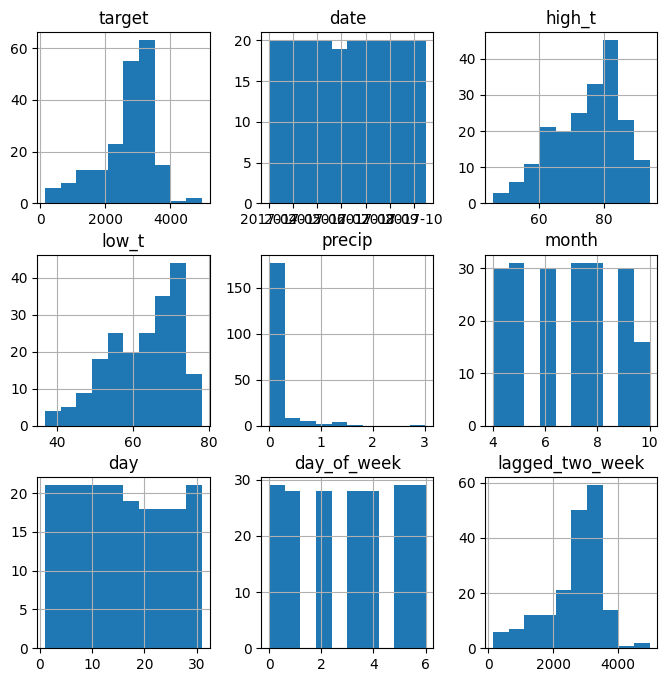

In [8]:
# 3.3 Display univariate analysis - Numeric 
df_train.hist(figsize=(8,8))
plt.show()

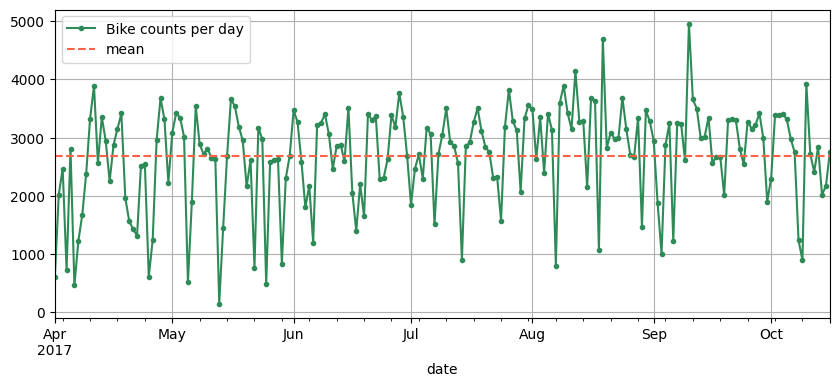

In [9]:
# 3.4 Show trend analysis
(
    df_train.set_index('date').loc[:,'target'].resample("D")
    .sum().plot(marker='.',c='seagreen', figsize=(10,4))
)
plt.axhline(df_train['target'].mean(), c='tomato', linestyle='--')
plt.grid(True)
plt.legend(['Bike counts per day','mean'])
plt.show()

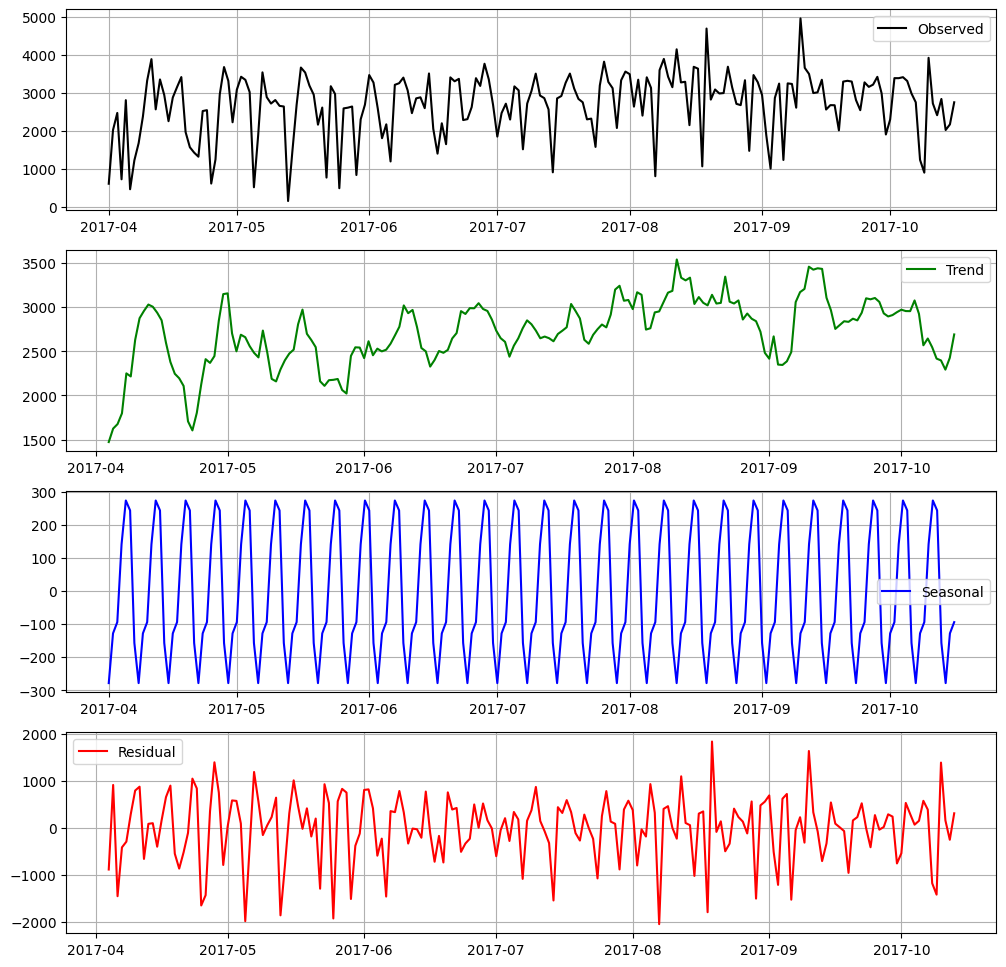

In [10]:
# 3.5 Show seasonal decomposition
data = seasonal_decompose(df_train.set_index('date').loc[:,"target"])
data_observed = data.observed
data_trend = data.trend
data_seasonal = data.seasonal
data_residual = data.resid
fig, ax = plt.subplots(4,1, figsize=(12,12))
ax[0].plot(data_observed, label="Observed", c="k")
ax[1].plot(data_trend, label="Trend", c="g")
ax[2].plot(data_seasonal, label="Seasonal", c="b")
ax[3].plot(data_residual, label="Residual", c="r")
for i in range(4):
    ax[i].grid(True)
    ax[i].legend()
plt.show()

### 4. Machine learning
**Objective**: Create a model that learns from data to make predictions and generalize to unseen data, and thus perform tasks without explicit instructions

In [11]:
# Step 4. Create a machine learning model
# 4.1 Create GLM expression in patsy notation
expr = """target ~ day + day_of_week + month + high_t + low_t + precip"""
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

In [12]:
# 4.2 Fit the model
poisson_reg = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(poisson_reg.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 target   No. Observations:                  199
Model:                            GLM   Df Residuals:                      192
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14163.
Date:                Fri, 06 Dec 2024   Deviance:                       26404.
Time:                        14:33:18   Pearson chi2:                 2.63e+04
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       7.0077      0.012    607.655      

#### 4.1 Find the right alpha
Poisson regression requires that variance be equal to mean. But this assumption does not hold for all the cases. Negative binomial regression does not require that assumption, however it requires a parametes $\alpha$ which is used to express the variance in terms of the mean:  

$ Variance = mean + \alpha * mean^p $  

In practice, this equation takes one of two commonly occurring forms:  

When p = 1 (NB1 model):  
$ Variance = mean * (1 + \alpha) $  

When p = 2 (NB2 model):  
$ Variance = mean + \alpha * mean^2 $  

To find a correct value of $\alpha$, we could use a formula given by Cameron and Trivedi [1]:  
$$ \frac{(y_i - \lambda_i)^2 - \lambda_i}{\lambda_i} = \alpha * \lambda_i + 0$$  
Where $y_i$ = $i^th$ outcome, and $\lambda_i$ = $i^th$ rate



In [13]:
# 4.3 Update the train dataset with the mu value
df_train_up = df_train.copy()
df_train_up['bb_lambda'] = poisson_reg.mu
df_train_up['aux_ols_dep'] = (
    df_train_up.apply(
        lambda x: ((x['target']-x['bb_lambda'])**2 -x['bb_lambda'])/x['bb_lambda'], 
        axis=1)
)

In [14]:
# 4.4 Create a new expression and fit the model to get lambda coefficient
expr_up = """aux_ols_dep ~ bb_lambda - 1"""
ols_reg_up = smf.ols(expr_up, df_train_up).fit()
print(ols_reg_up.params)

bb_lambda    0.038151
dtype: float64


In [15]:
# 4.5 Create the negative binomial model
alpha = ols_reg_up.params.to_list()[0]
nbinomial_reg = (
    sm.GLM(y_train, X_train, 
           family=sm.families.NegativeBinomial(alpha=alpha)).fit() 
)
print(nbinomial_reg.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 target   No. Observations:                  199
Model:                            GLM   Df Residuals:                      192
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1607.9
Date:                Fri, 06 Dec 2024   Deviance:                       384.71
Time:                        14:33:18   Pearson chi2:                     341.
No. Iterations:                    10   Pseudo R-squ. (CS):             0.8905
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       6.7189      0.109     61.595      

In [16]:
# 4.6 Predict for the test dataset
y_pred = nbinomial_reg.get_prediction(X_test)
print(y_pred.summary_frame())

            mean     mean_se  mean_ci_lower  mean_ci_upper
199  2574.144433  152.606525    2291.764384    2891.317977
200  3355.574964  186.410201    3009.405203    3741.564389
201  2847.971944  113.696497    2633.626055    3079.763044
202  2960.775696  116.462491    2741.090569    3198.067522
203  3473.937146  174.346241    3148.493232    3833.020560
204  3184.792096  157.577195    2890.449080    3509.108936
205  2919.490094  119.314312    2694.758988    3162.962790
206  2336.271181   92.925045    2161.059686    2525.688238
207  2383.045851  106.653763    2182.914262    2601.525688
208  1999.749927  107.381805    1799.982138    2221.688586
209  2540.582218  144.603573    2272.401123    2840.413138
210  2587.676426  125.876621    2352.358808    2846.533983
211   330.078647   43.606308     254.780496     427.630509
212  1949.536109  130.275286    1710.215414    2222.346384
213  2245.091099  152.091058    1965.940275    2563.879538


In [17]:
# 4.7 Calculate metrics
y_hat = y_pred.summary_frame()['mean']
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_hat)):.1f}')
print(f'MAE: {np.sqrt(mean_absolute_error(y_test, y_hat)):.1f}')
print(f'R2: {np.sqrt(r2_score(y_test, y_hat)):.2f}')

RMSE: 614.7
MAE: 22.6
R2: 0.74


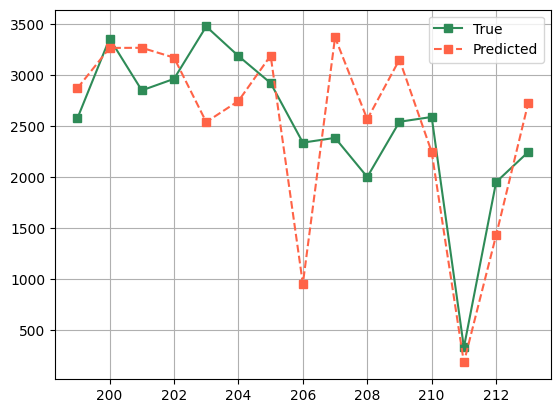

In [18]:
plt.plot(y_pred.summary_frame()['mean'], c='seagreen', marker='s')
plt.plot(y_test, c='tomato', marker='s', linestyle='--')
plt.grid(True)
plt.legend(['True','Predicted'])
plt.show()

### 5. Model saving
**Objective**: Save the model and some critical information we consider necessary

In [19]:
# Step 5. Save the model for further usage
# 5.1 Create model dictionary
model_dict = {
    'model': nbinomial_reg,
    'predictors': X_train.columns.to_list(),
    'target_name': 'bb_count',
    'algorithm_name': 'Negative Binomial Regression'
}

In [20]:
# 5.2 Save the model dictionary
try:
    joblib.dump(model_dict, '../models/bike_counts_model_dict.joblib')
    logger.info("Save succesful")
except Exception as e:
    logger.error(f"An error occurred: {e}")